In [2]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score


In [4]:
# Step 2: Load Dataset
df = pd.read_csv("IMDB Dataset.csv")
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})


In [6]:
# Step 3: Text Preprocessing (basic)
def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)       # remove HTML tags
    text = re.sub(r"[^a-z\s]", "", text)    # keep only letters
    return text

df['review'] = df['review'].apply(clean_text)


In [8]:
# Step 4: Split Data
X_train, X_test, y_train, y_test = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42)

# Step 5: Vectorize using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

In [10]:
# Step 6: Define Neural Network Class (1 hidden layer)
class SimpleNN:
    def __init__(self, input_size, hidden_size, output_size):
        # Xavier initialization
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1 / hidden_size)
        self.b2 = np.zeros((1, output_size))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, a):
        return a * (1 - a)

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = self.sigmoid(self.Z2)
        return self.A2

    def compute_loss(self, y_true, y_pred):
        epsilon = 1e-10
        return -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))

    def backward(self, X, y_true, y_pred, lr=0.01):
        m = X.shape[0]
        dZ2 = y_pred - y_true
        dW2 = self.A1.T @ dZ2 / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = X.T @ dZ1 / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W1 -= lr * dW1
        self.b1 -= lr * db1

    def train(self, X, y, epochs=20, lr=0.01):
        losses = []
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = self.compute_loss(y, y_pred)
            self.backward(X, y, y_pred, lr)
            losses.append(loss)
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}")
        return losses

    def predict(self, X):
        probs = self.forward(X)
        return (probs >= 0.5).astype(int)


In [12]:
# Step 7: Train the Model
input_size = X_train_vec.shape[1]
nn = SimpleNN(input_size=input_size, hidden_size=64, output_size=1)


In [14]:
# Reshape labels to (n,1)
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

losses = nn.train(X_train_vec, y_train_reshaped, epochs=20, lr=0.1)


Epoch 1/20 - Loss: 0.6927
Epoch 2/20 - Loss: 0.6927
Epoch 3/20 - Loss: 0.6926
Epoch 4/20 - Loss: 0.6926
Epoch 5/20 - Loss: 0.6926
Epoch 6/20 - Loss: 0.6925
Epoch 7/20 - Loss: 0.6925
Epoch 8/20 - Loss: 0.6924
Epoch 9/20 - Loss: 0.6924
Epoch 10/20 - Loss: 0.6924
Epoch 11/20 - Loss: 0.6923
Epoch 12/20 - Loss: 0.6923
Epoch 13/20 - Loss: 0.6923
Epoch 14/20 - Loss: 0.6922
Epoch 15/20 - Loss: 0.6922
Epoch 16/20 - Loss: 0.6921
Epoch 17/20 - Loss: 0.6921
Epoch 18/20 - Loss: 0.6921
Epoch 19/20 - Loss: 0.6920
Epoch 20/20 - Loss: 0.6920


In [16]:
# Step 8: Evaluate the Model
y_pred = nn.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")



Test Accuracy: 0.5426


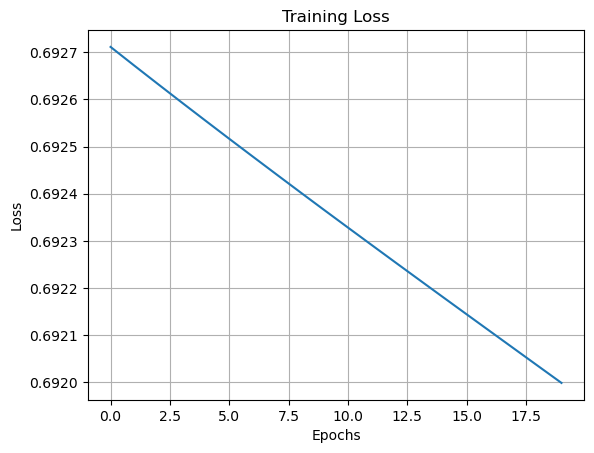

In [18]:
# Step 9: Plot Loss Curve
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()